In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt
from numpy import format_float_scientific as ffs
import sys
sys.path.append("..")
import time as Time
torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=10)
device = 'cpu'

In [2]:
%load_ext autoreload
%autoreload 2
from Inverse_Parameter import a, a_b, dc, b, sigma, k, eta, vpl, statepl,t1, t2, v_ini, state_ini, time_span

In [3]:
from PINN_Preparation import Training_Tensor
collocation_points = np.arange(t1, t2, time_span) - t1
collocation_points = collocation_points.reshape([1, -1])
Tensors = Training_Tensor(collocation_points, vpl, statepl, v_ini, state_ini)
Nt, ub, lb, t_ini_train, u_ini_train, t_f_train, t_test_tensor, f_hat = Tensors.Output()

In [4]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        self.loss_hist = []
        self.lossini_hist = []
        self.lossf_hist = []
        self.lossd_hist = []

        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
            
    #foward computation
    def forward(self,t):
        
        if torch.is_tensor(t) != True:         
            t = torch.from_numpy(t)           
        
        u_b = torch.from_numpy(ub).double().to(device)
        l_b = torch.from_numpy(lb).double().to(device)
        t = (t - l_b)/(u_b - l_b)
        a = t.double() #convert to double
        for i in range(len(layers)-2):         
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        
        return a

    #loss function induced from initial condition
    def loss_IC(self,t,y):
        
        z = t.clone()
        z.requires_grad = True
        u = self.forward(z)
        loss_u = self.loss_function(u[0, :], y[0, :])#velocity and state
        u_0 = torch.reshape(u[:,0],(t.shape[0],1)) #v
        u_1 = torch.reshape(u[:,1],(t.shape[0],1)) #theta
        
        velocity = vpl * torch.exp(u_0)
        state    = statepl * torch.exp(u_1)
        
        if self.iter <= 9:
            print('step=',self.iter, "P_ini",u_0.item(),y[0,0].item())
            print('step=',self.iter, "Q_ini",u_1.item(),y[0,1].item())
            #print('step=',self.iter, "x_ini",u.item(),y[0,0].item())
        if self.iter % 100 == 0:
            print('step=',self.iter, "P_ini",u_0.item(),y[0,0].item())
            print('step=',self.iter, "Q_ini",u_1.item(),y[0,1].item())
            #print('step=',self.iter, "x_ini",u.item(),y[0,0].item())
                
        return loss_u, velocity, state

    #loss function induced from governing equation
    def loss_PDE(self, t):
                       
        z = t.clone()
        z.requires_grad = True
        
        u = self.forward(z)
        u_0 = torch.reshape(u[:,0],(t.shape[0],1)) #v
        u_1 = torch.reshape(u[:,1],(t.shape[0],1)) #state
        P_t = autograd.grad(u_0,z,torch.ones([t.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        Q_t = autograd.grad(u_1,z,torch.ones([t.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        velocity = vpl * torch.exp(u_0)
        state    = statepl * torch.exp(u_1)
        
        #Governing euqation
        eps = 1.0e-30
        ap = torch.exp(logap)
        a_bp = - torch.exp(loga_bp)
        dcp = torch.exp(logdcp)
        
        p = ap / (velocity + eps) + eta / sigma
        r = 1.0 - velocity * state / dcp
        q = k / sigma * (vpl - velocity) -(ap - a_bp) * r / (state + eps)

        f_P = P_t - q / (p * velocity)
        f_Q = Q_t - r / state
        Lr = (f_P ** 2 + f_Q ** 2)[:, 0]
        t_ = z[:,0]
        loss_f = Lr[0]*(t_[1]-t_[0]) + Lr[-1]*(t_[-1]-t_[-2]) + torch.sum(Lr[1:-1]*(t_[2:]-t_[0:-2]))
        loss_f = loss_f / 2 * (dc / vpl)
  
        dv_dt = velocity * P_t 
        dstate_dt = state * Q_t
                
        return loss_f, dv_dt, dstate_dt

    def loss_data(self, t, v_data):
        z = t.clone()
        z.requires_grad = True
        
        u = self.forward(z)
        u_0 = torch.reshape(u[:,0],(t.shape[0],1)) #v

        p_data = torch.log(v_data / vpl)
        norm = torch.dist(u_0[:, 0], p_data[:, 0], p = 2)
        loss_d = norm ** 2 / len(v_data[:, 0])
        
        return loss_d

    def loss(self,t_ini_train,u_ini_train, t_f_train, t_data, v_data):
        loss_ini, v_ini, state_ini = self.loss_IC(t_ini_train,u_ini_train)
        loss_f, dv_dt, dstate_dt = self.loss_PDE(t_f_train)
        loss_d = self.loss_data(t_data, v_data)
        loss_val = loss_ini + weight*loss_f  + weight2*loss_d

        return loss_val, loss_ini, loss_f, loss_d, dv_dt, dstate_dt, v_ini, state_ini
                                      
    def closure(self):
        
        optimizer.zero_grad()
        loss ,loss_ini, loss_f, loss_d, dv_dt, dstate_dt, v_ini, state_ini \
        = self.loss(t_ini_train,u_ini_train,t_f_train, t_data, v_data)
        self.loss_hist.append(loss.item())
        self.lossini_hist.append(loss_ini.item())
        self.lossf_hist.append(loss_f.item())
        self.lossd_hist.append(loss_d.item())
        loss.backward()        
        self.iter += 1
        
        if self.iter <= 9:
            _ = PINN.test()
            print('step=',self.iter, 'loss=', loss.item(),loss_ini.item(), loss_f.item(), loss_d.item())

        if self.iter % 100 == 0:
            _ = PINN.test()
            print('step=',self.iter, 'loss=', loss.item(),loss_ini.item(), loss_f.item(), loss_d.item())

        return loss
    
    def test(self):
                
        u_pred = self.forward(t_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
        u_pred = np.reshape(u_pred,(Nt,2),order='F')
                
        return u_pred

In [5]:
import Inverse_Synthetic_data as isd
from Inverse_Parameter import obs_error, obs_start, obs_end, obs_span
layers, True_NN = isd.Load_Solution(Sequentialmodel)
with torch.no_grad():
    t_data, v_data = isd.Make_Synthetic(obs_error, obs_start, obs_end, obs_span, True_NN)

In [6]:
from PINN_Save import Save_Loss_inverse, Save_PINN_inverse
from Inverse_Parameter import a_ini, a_b_ini, dc_ini, seed, max_iteration, fp_epsilon, filename, save

start = Time.time()
torch.manual_seed(seed); np.random.seed(seed) #Fix seed 

logap = torch.tensor(np.log(a_ini * a), requires_grad = True).double().to(device)
loga_bp = torch.tensor(np.log(- a_b_ini * a_b), requires_grad = True).double().to(device)
logdcp = torch.tensor(np.log(dc_ini * dc), requires_grad = True).double().to(device)
ap = torch.exp(logap); a_bp = - torch.exp(loga_bp); dcp = torch.exp(logdcp)

weight = 1; weight2 = 1;
layers = np.array([1,20,20,20,20,20,20,20,20,2])
PINN = Sequentialmodel(layers).to(device)

params = list(PINN.parameters())
params.append(logap); params.append(loga_bp); params.append(logdcp)

optimizer = torch.optim.LBFGS(params, lr=1.0, 
                              max_iter = 1, 
                              max_eval = 100, 
                              tolerance_grad = 1e-20, 
                              tolerance_change = 1e-6 * 1e-6, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

fp_list = {"a":[ap.item() / a], "a-b":[a_bp.item() / a_b], "dc":[dcp.item() / dc]}
loss_list ={"total":[0], "ini":[], "ode":[], "data":[]}

for i in range(max_iteration):
    optimizer.step(PINN.closure)
    Ests = [logap, loga_bp, logdcp]
    Save_Loss_inverse(PINN, loss_list, fp_list, Ests)
    dela   = abs(fp_list["a"][-1] - fp_list["a"][-2]);
    dela_b = abs(fp_list["a-b"][-1] - fp_list["a-b"][-2]);
    deldc  = abs(fp_list["dc"][-1] - fp_list["dc"][-2])
    if(max([dela, dela_b, deldc]) < fp_epsilon):
        break
del loss_list["total"][0]

Save_PINN_inverse(PINN, filename, loss_list, fp_list)

end = Time.time()
print("Traininig time = ", end - start, " [s]")

step= 0 P_ini 0.0 -1.7093871951979658
step= 0 Q_ini 0.0 1.4142093109815335
step= 0 P_ini 0.0 -1.7093871951979658
step= 0 Q_ini 0.0 1.4142093109815335
step= 1 loss= 27.566732697408035 2.460996279186816 23.38642379024654 1.71931262797468
step= 1 P_ini 0.027723235018128598 -1.7093871951979658
step= 1 Q_ini 0.10880409468689427 1.4142093109815335
step= 2 loss= 20.80095224198367 2.3608177127473993 16.680890636563976 1.7592438926722958
step= 2 P_ini 0.027723235018128598 -1.7093871951979658
step= 2 Q_ini 0.10880409468689427 1.4142093109815335
step= 3 loss= 20.80095224198367 2.3608177127473993 16.680890636563976 1.7592438926722958
step= 3 P_ini 0.07600810412554537 -1.7093871951979658
step= 3 Q_ini 0.46321876079610663 1.4142093109815335
step= 4 loss= 9.389964037704337 2.0460097006942357 5.520548713880748 1.8234056231293532
step= 4 P_ini 0.07600810412554537 -1.7093871951979658
step= 4 Q_ini 0.46321876079610663 1.4142093109815335
step= 5 loss= 9.389964037704337 2.0460097006942357 5.520548713880748

step= 3100 loss= 0.010819905306109788 3.560655050690757e-06 0.0003136181559729851 0.010502726495086111
step= 3100 P_ini -1.7112812582988641 -1.7093871951979658
step= 3100 Q_ini 1.4123294612345598 1.4142093109815335
step= 3200 loss= 0.01072592247320685 3.3101187722640174e-06 0.0002341678307188107 0.010488444523715775
step= 3200 P_ini -1.7112445514630528 -1.7093871951979658
step= 3200 Q_ini 1.4124287309498949 1.4142093109815335
step= 3300 loss= 0.010699930382142874 2.248100643347645e-06 0.00021366314809091042 0.010484019133408616
step= 3300 P_ini -1.7112292742340487 -1.7093871951979658
step= 3300 Q_ini 1.413397106830421 1.4142093109815335
step= 3400 loss= 0.01068364768929285 1.2811503105371486e-06 0.0001934808109778276 0.010488885728004485
step= 3400 P_ini -1.7106992846679678 -1.7093871951979658
step= 3400 Q_ini 1.4132924021290383 1.4142093109815335
step= 3500 loss= 0.010662008913541118 4.183244001974065e-07 0.0001724275051732331 0.010489163083967688
step= 3500 P_ini -1.7099858012359586 

Estimated a  :  1.01e-04  True a  :  1.e-04  Ini a  :  1.000e-03
Estimated a-b:  -9.984e-06 True a-b:  -1.e-05 Ini a-b:  -1.000e-06
Estimated dc :  4.928e-03  True dc :  5.e-03  Ini dc :  5.000e-02


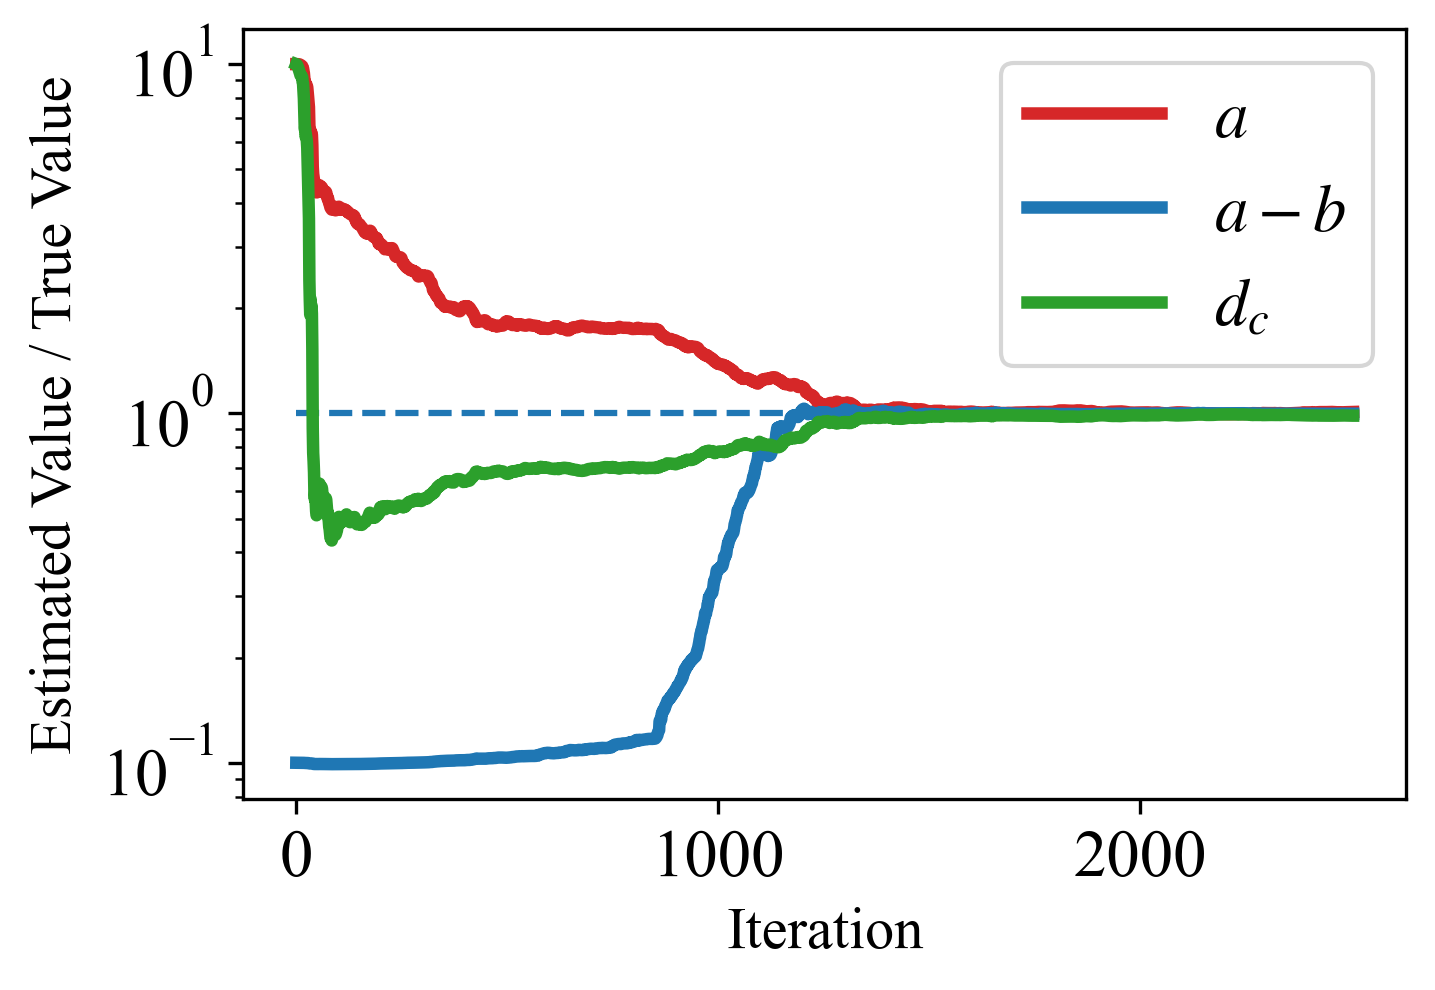

L    :  1.055e-02
Lode :  6.534e-05
Lini :  1.096e-06
Ldata:  1.049e-02
Iteration :  2505


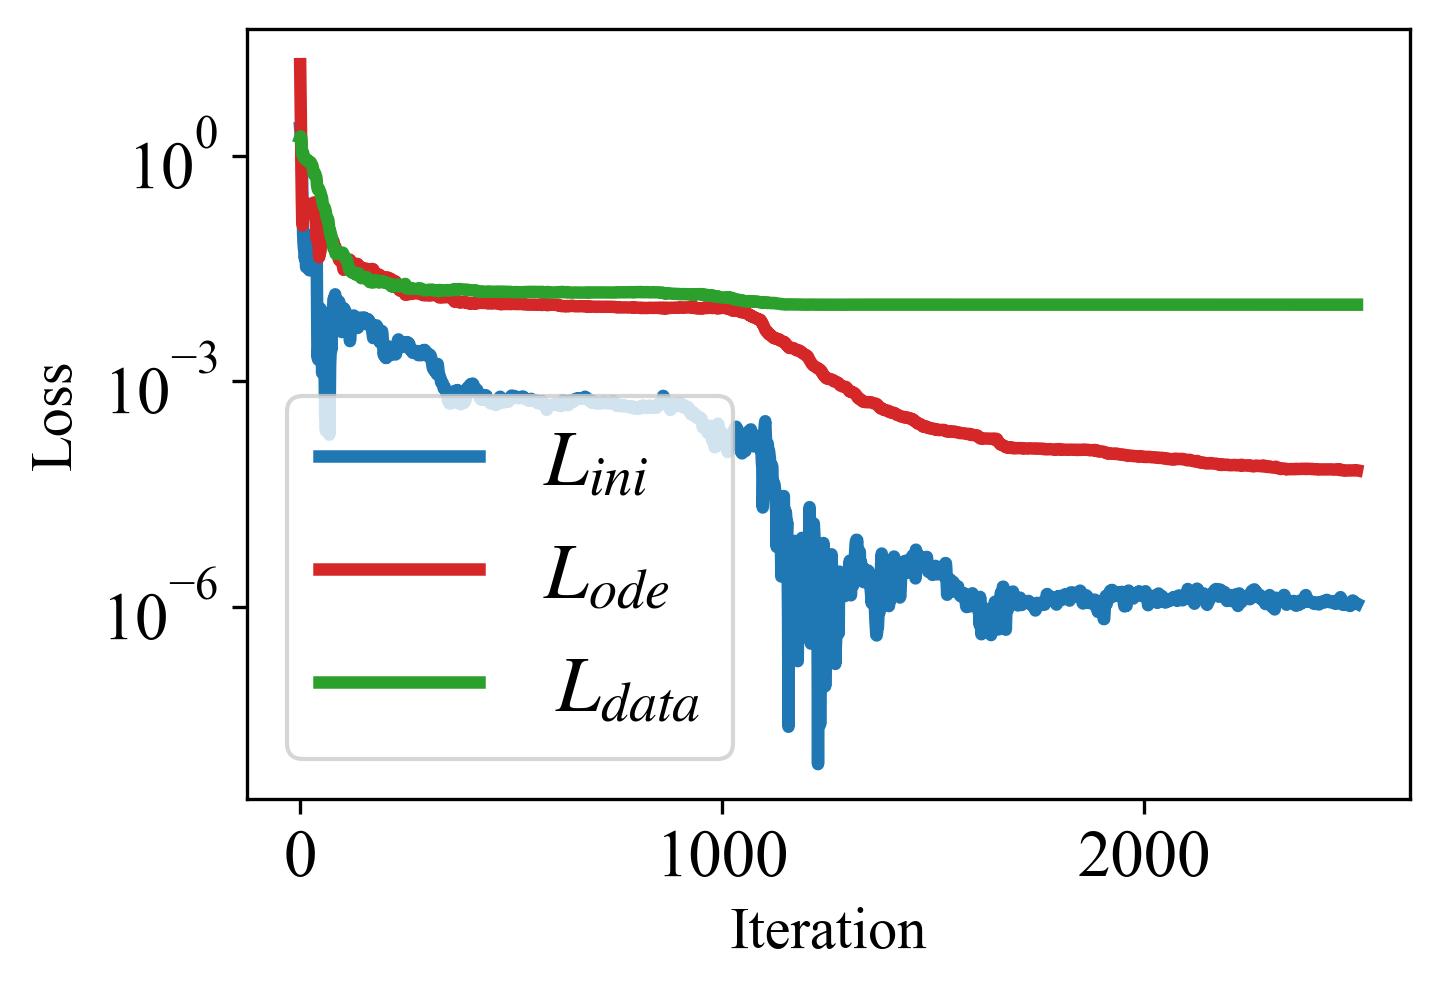

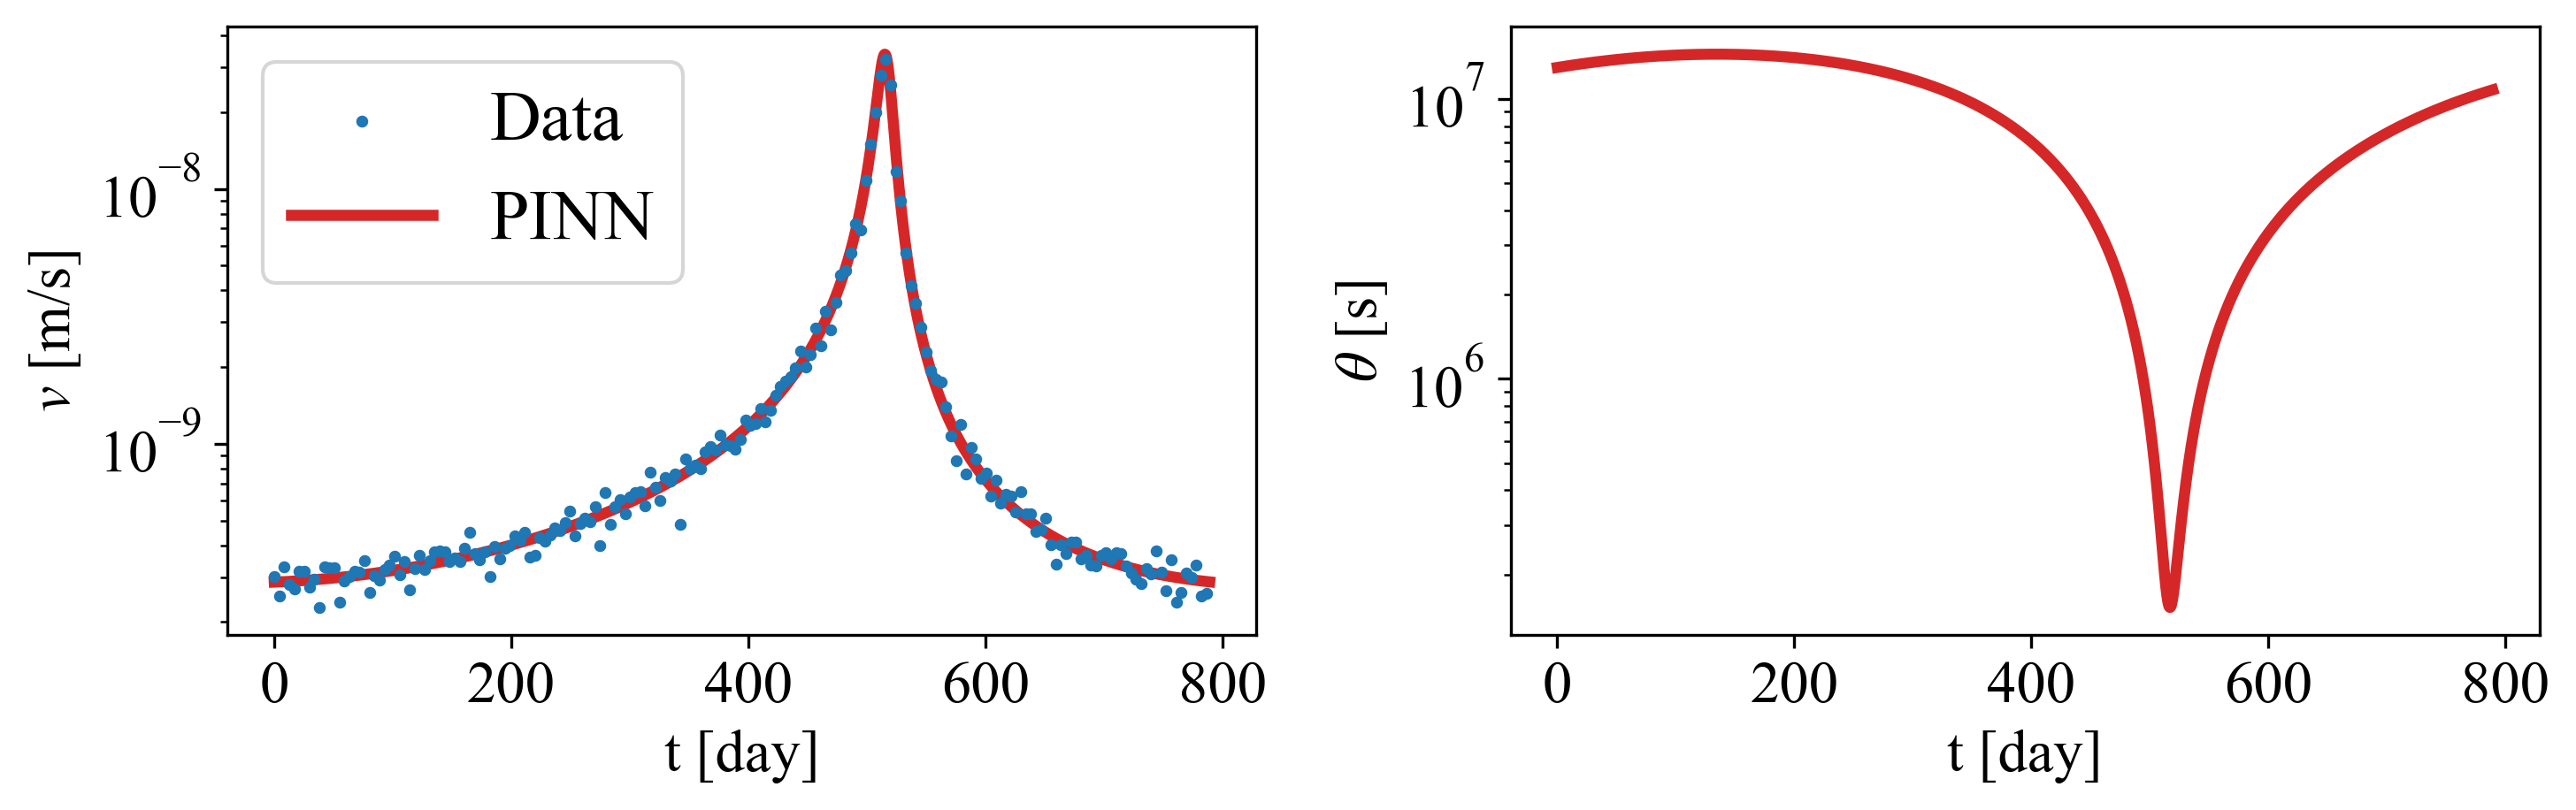

In [7]:
from Inverse_Plot import Result
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
Result = Result(PINN, loss_list, fp_list, filename)
Result.plot_parameter(save)
Result.plot_loss(save)
Result.plot_vtheta(t_data, v_data, save)